# 2ème version des simulations

Cas :
- prix fixes 
- proba = 1
- ajouts de pb techniques

In [1]:
import numpy as np
import random 
import simpy

L'objectif est de créer une dynamique aléatoire d'arrivée des bid requests qui suivent une certaine variable aléatoire. On ne connaît pas donc le nombre de BR sur une période donnée. ```Filtre de Kalman``` pour obtenir des estimations dynamiques.

Le déroulement est le suivant :
1. Fixer les constantes globales : Budget, proba de gagner, prix de chaque impression, horaires de la journée
2. Générer les variables aléatoires pour les bids requests et les impressions associées
3. Simuler avec un simulateur à événement discret l'arrivée des bid requests + pacing/sec sans algo
4. Implémenter une estimation dynamique du nombre d'impressions (prix par impression)
5. Determiner une probabilité d'achat d'une br selon le nombre d'impressions estimée
6. Mesure de performances (ecart au budget, nb d'impressions gagnées etc.)

### Etape 1 - Constantes globales

On va supposer que l'on connaît les horaires d'une journée (8h - 18h) 

On connaît le budget (1000 euros par heure)

On connaît le prix (1 euro par impression)

On gagne à chaque bid

In [2]:
nombre_heures = 10
B = 1800
P = 1

### Etape 2 - Générer les variables aléatoires

1) Variable aléatoire sur le délai entre chaque bid request 

2) Variable aléatoire sur le nombre d'impressions par bid request ------- Note : au début les deux ne sont pas forcément liés mais à termes on pourra instaurer une dépendance (plus proche de la réalité)

In [39]:
def delai():
    secondes = np.random.poisson(2)
    if not random.random() < 0.98:
        secondes = np.random.poisson(600)
    return secondes

In [4]:
def imps():
    nb_imp = np.random.poisson(3)
    return nb_imp

In [5]:
def bid_proba(p):
    return random.random() < p

### Etape 3 - Simulation

In [6]:
def open_rtb(env):
    B = 30
    duree_totale = 60
    cible = B/duree_totale
    while True:
        # Nombre d'impressions
        nb_imp = imps()
        print(f"bid request avec {nb_imp} impressions")
        number_imps_br.append(nb_imp)
        
        # Calcul du budget par seconde restant
        rt = duree_totale - env.now
        B_sec = B/rt
        b_sec.append(B_sec)
        print(f"\t Budget par sec de {B_sec} euros")
        
        # Proba d'acheter
        if B_sec >= cible:
            proba = 1
        else:
            proba = 0
        
        # Achat ou pas
        if bid_proba(proba):
            B -= 1
            print(f"\t Achat de {P} euros. Il reste {B} euros")
        else:
            print(f"\t Pas d'achat. Il reste {B} euros")
        B_remain.append(B)
        
        # Temps restant de la simulation
        print(f"\t Il reste {rt} secondes avant la fin de la simulation \n")
        
        # Temps avant la prochaine BR
        time = delai() 
        
        # Test pour faire des trucs a la fin de la simulation
        if rt < time:
            print("Fin de la simulation")
            print(f"Le budget restant est de {B} euros")
        yield env.timeout(time)

In [7]:
env = simpy.rt.RealtimeEnvironment(factor=1.0, strict=False)
proc = env.process(open_rtb(env))

In [8]:
number_imps_br = []
b_sec = []
B_remain = []
env.run(until=60)

bid request avec 3 impressions
	 Budget par sec de 0.5 euros
	 Achat de 1 euros. Il reste 29 euros
	 Il reste 60 secondes avant la fin de la simulation 

bid request avec 1 impressions
	 Budget par sec de 0.5 euros
	 Achat de 1 euros. Il reste 28 euros
	 Il reste 58 secondes avant la fin de la simulation 

bid request avec 4 impressions
	 Budget par sec de 0.49122807017543857 euros
	 Pas d'achat. Il reste 28 euros
	 Il reste 57 secondes avant la fin de la simulation 

bid request avec 7 impressions
	 Budget par sec de 0.509090909090909 euros
	 Achat de 1 euros. Il reste 27 euros
	 Il reste 55 secondes avant la fin de la simulation 

bid request avec 3 impressions
	 Budget par sec de 0.5094339622641509 euros
	 Achat de 1 euros. Il reste 26 euros
	 Il reste 53 secondes avant la fin de la simulation 

bid request avec 0 impressions
	 Budget par sec de 0.5306122448979592 euros
	 Achat de 1 euros. Il reste 25 euros
	 Il reste 49 secondes avant la fin de la simulation 

bid request avec 2 im

Essayons de changer quelques constantes pour voir ce qu'il se passe. 

Il faudrait aussi intégrer le fait que l'algo doit tourner sur toute une journée de 10h.

In [41]:
def open_rtb(env, B, duree_totale_heure, P):
    duree_totale = duree_totale_heure * 3600
    cible = B/duree_totale
    while True:
        # Nombre d'impressions
        nb_imp = imps()
        number_imps_br.append(nb_imp)
        
        # Calcul du budget par seconde restant
        rt = duree_totale - env.now
        B_sec = B/rt
        b_sec.append(B_sec)
        
        # Proba d'acheter
        if B_sec >= cible:
            proba = 1
        else:
            proba = 0
        
        # Achat ou pas
        if bid_proba(proba):
            B -= P
        B_remain.append(B)
        
        # Temps avant la prochaine BR
        time = delai()
        
        # Test pour faire des trucs a la fin de la simulation
        if rt < time:
            print("Fin de la simulation")
            print(f"Le budget restant est de {B} euros")
        yield env.timeout(time)

In [80]:
# Paramètres à changer
nombre_heures = 10
B = 1000
P = 5

In [81]:
env = simpy.Environment()
proc = env.process(open_rtb(env, B, nombre_heures, P))

In [82]:
number_imps_br = []
b_sec = []
B_remain = []
duree_totale_sec = nombre_heures * 3600
env.run(until=duree_totale_sec)

Fin de la simulation
Le budget restant est de 10 euros


In [83]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


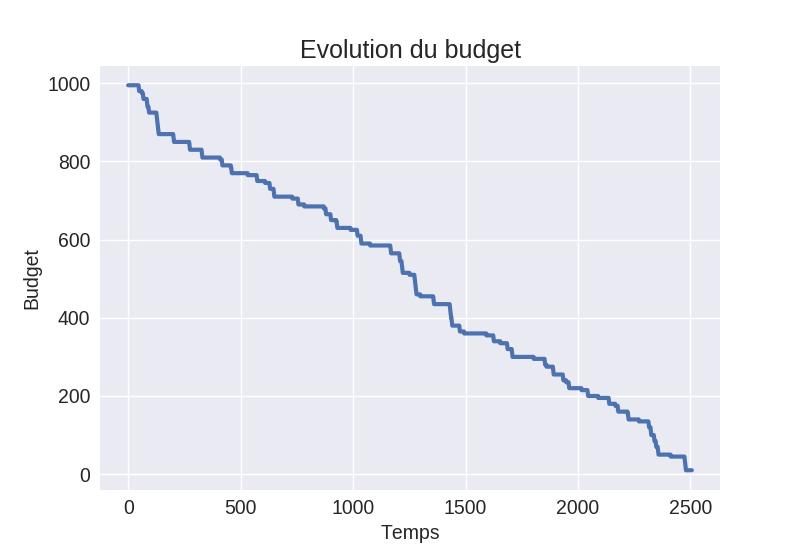

In [84]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(B_remain, linewidth=3)
# Set chart title and label axes.
ax.set_title("Evolution du budget", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Budget", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

<IPython.core.display.Javascript object>


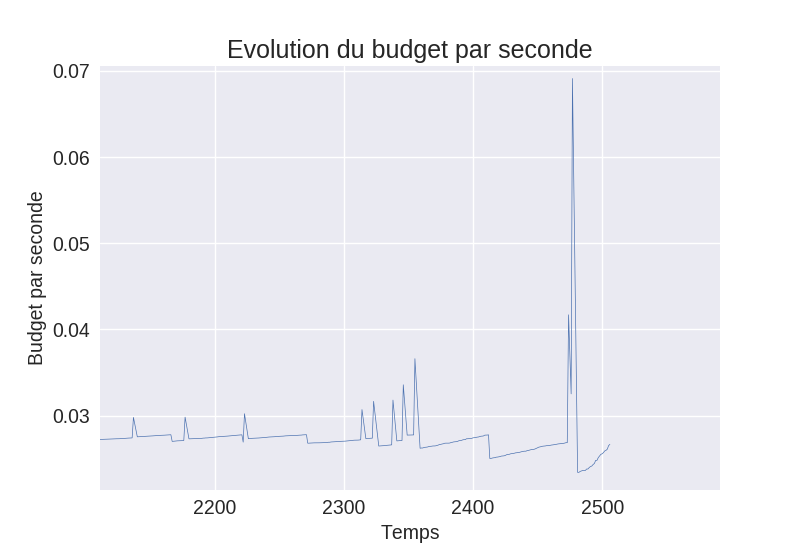

In [85]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(b_sec, linewidth=.5)
# Set chart title and label axes.
ax.set_title("Evolution du budget par seconde", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Budget par seconde", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

Le problème actuel est qu'il y a toujours un pic de budget par seconde en fin de période et donc ce n'est pas forcément efficient. L'objectif serait d'annihiler cet effet pic à la fin.

Mais tout d'abord nous devons essaer d'améliorer la simulation afin qu'elle colle plus à la réalité. Nous pouvons par exemple déterminer un prix fixe par impression et non pas par BR. 

### Etape 4 - Prix par impression

In [94]:
def open_rtb(env, B, duree_totale_heure, P):
    duree_totale = duree_totale_heure * 3600
    cible = B/duree_totale
    while True:
        # Nombre d'impressions
        nb_imp = imps()
        Prix = P * nb_imp
        prix_liste.append(Prix)
        
        # Calcul du budget par seconde restant
        rt = duree_totale - env.now
        B_sec = B/rt
        b_sec.append(B_sec)
        
        # Proba d'acheter
        if B_sec >= cible:
            proba = 1
        else:
            proba = 0
        
        # Achat ou pas
        if bid_proba(proba):
            B -= Prix
        B_remain.append(B)
        
        # Temps avant la prochaine BR
        time = delai()
        
        # Test pour faire des trucs a la fin de la simulation
        if rt < time:
            print("Fin de la simulation")
            print(f"Le budget restant est de {B} euros")
        yield env.timeout(time)

In [104]:
# Paramètres à changer
nombre_heures = 10
B = 1000
P = 1

In [105]:
env = simpy.Environment()
proc = env.process(open_rtb(env, B, nombre_heures, P))

In [106]:
b_sec = []
B_remain = []
prix_liste = []
duree_totale_sec = nombre_heures * 3600
env.run(until=duree_totale_sec)

Fin de la simulation
Le budget restant est de 0 euros


<IPython.core.display.Javascript object>


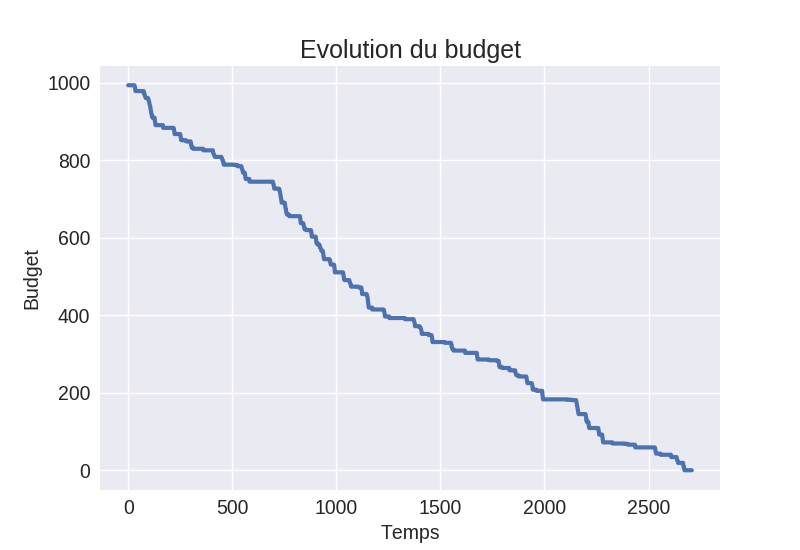

In [107]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(B_remain, linewidth=3)
# Set chart title and label axes.
ax.set_title("Evolution du budget", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Budget", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

<IPython.core.display.Javascript object>


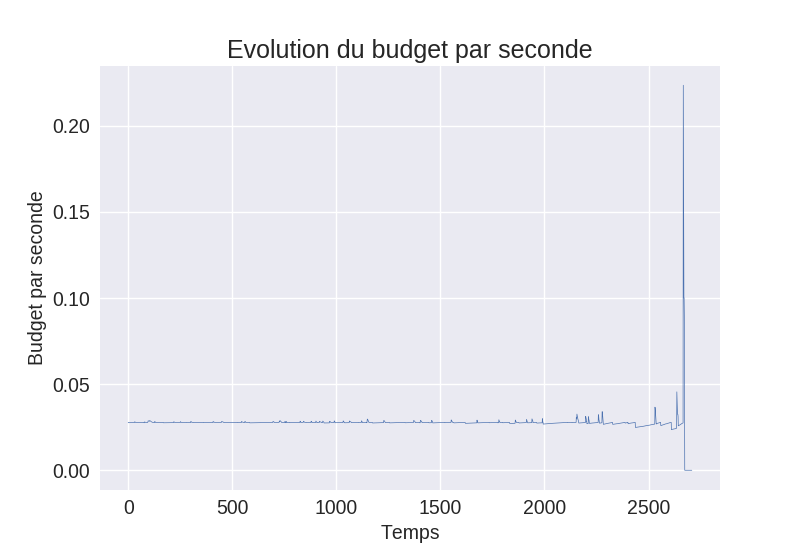

In [108]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(b_sec, linewidth=.5)
# Set chart title and label axes.
ax.set_title("Evolution du budget par seconde", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Budget par seconde", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

<IPython.core.display.Javascript object>


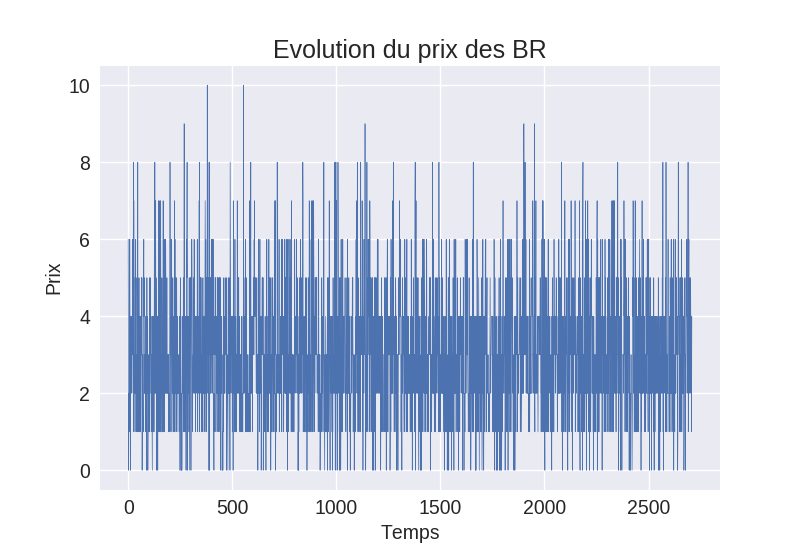

In [109]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(prix_liste, linewidth=.5)
# Set chart title and label axes.
ax.set_title("Evolution du prix des BR", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Prix", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

Le budget a été dépensé totalement (ou presque selon les simulations) sur toute la journée donc le pacing semble bien fonctionner. Cependant il y a toujours le problème de pic de dépense en fin de journée.